<a href="https://colab.research.google.com/github/John1495/RNA-3D/blob/main/gcnconv_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 37.8 MB/s eta 0:00:00


In [ ]:
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import joblib
from tqdm import tqdm

# Load data
seq_df = pd.read_csv('/kaggle/cleaned_train_sequences2 (1).csv')
label_df = pd.read_csv('/kaggle/train_labels1.csv')
label_df['resname'] = label_df['resname'].str.extract(r'([AUGC])')
label_df = label_df.dropna(subset=['resname'])
label_df['target_id'] = label_df['ID'].str.extract(r'(.+)_\d+')
merged = pd.merge(label_df, seq_df[['target_id', 'sequence']], on='target_id', how='left')

# Filter complete cases only
complete_ids = merged.groupby('target_id')['resid'].count()
valid_ids = complete_ids[complete_ids > 10].index
merged = merged[merged['target_id'].isin(valid_ids)]

# Train-validation split
all_ids = merged['target_id'].unique()
train_ids, val_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

residue_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3}

def create_graph_from_group(df_group, scaler=None, fit_scaler=False):
    sequence = df_group['sequence'].values[0]
    coords = df_group[['x_1', 'y_1', 'z_1']].values
    df_group = df_group.sort_values('resid')
    node_features = torch.eye(4)[[residue_mapping[r] for r in df_group['resname']]]

    if scaler is not None:
        if fit_scaler:
            coords = scaler.fit_transform(coords)
        else:
            coords = scaler.transform(coords)

    pos = torch.tensor(coords, dtype=torch.float)
    y = pos  # predict absolute coordinates

    n = len(df_group)
    edge_index = torch.tensor(
        [[i, i+1] for i in range(n-1)] + [[i+1, i] for i in range(n-1)],
        dtype=torch.long
    ).t().contiguous()

    return Data(x=node_features, edge_index=edge_index, pos=pos, y=y)

scaler = StandardScaler()
train_graphs, val_graphs = [], []
for tid in tqdm(train_ids):
    g = create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=True)
    train_graphs.append(g)

for tid in tqdm(val_ids):
    g = create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=False)
    val_graphs.append(g)

train_loader = DataLoader(train_graphs, batch_size=1)
val_loader = DataLoader(val_graphs, batch_size=1)

class GCNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNNet(input_dim=4, hidden_dim=32, output_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

best_val_loss = float('inf')
patience = 10
epochs_without_improvement = 0

model.train()
for epoch in range(100):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "MODEL_GCN.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

model.eval()
predictions, true = [], []
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        pred = model(batch)
        predictions.append(pred.cpu().numpy())
        true.append(batch.y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true = np.concatenate(true, axis=0)

rmse = np.sqrt(mean_squared_error(true, predictions))
mae = mean_absolute_error(true, predictions)

def calculate_tm_score(true, pred):
    d = np.linalg.norm(true - pred, axis=1)
    N = true.shape[0]
    return np.mean(np.exp(-d / (0.5 * N)))

def calculate_rmsd(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

tm_score = calculate_tm_score(true, predictions)
rmsd = calculate_rmsd(true, predictions)

print("\nValidation Metrics:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"TM-Score: {tm_score:.6f}")
print(f"RMSD: {rmsd:.6f}")

# Save scaler
joblib.dump(scaler, "scaler_gcn.pkl")


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Epoch 0, Loss: 0.950426
Epoch 1, Loss: 0.948398
Epoch 2, Loss: 0.948096
Epoch 3, Loss: 0.947921
Epoch 4, Loss: 0.947832
Epoch 5, Loss: 0.947764
Epoch 6, Loss: 0.947692
Epoch 7, Loss: 0.947628
Epoch 8, Loss: 0.947601
Epoch 9, Loss: 0.947557
Epoch 10, Loss: 0.947528
Epoch 11, Loss: 0.947490
Epoch 12, Loss: 0.947471
Epoch 13, Loss: 0.947452
Epoch 14, Loss: 0.947434
Epoch 15, Loss: 0.947416
Epoch 16, Loss: 0.947399
Epoch 17, Loss: 0.947390
Epoch 18, Loss: 0.947366
Epoch 19, Loss: 0.947354
Epoch 20, Loss: 0.947329
Epoch 21, Loss: 0.947316
Epoch 22, Loss: 0.947295
Epoch 23, Loss: 0.947284
Epoch 24, Loss: 0.947271
Epoch 25, Loss: 0.947260
Epoch 26, Loss: 0.947255
Epoch 27, Loss: 0.947244
Epoch 28, Loss: 0.947226
Epoch 29, Loss: 0.947211
Epoch 30, Loss: 0.947204
Epoch 31, Loss: 0.947199
Epoch 32, Loss: 0.947185
Epoch 33, Loss: 0.947174
Epoch 34, Loss: 0.947179
Epoch 35, Loss: 0.947195
Epoch 36, Loss: 0.947174
Epoch 37, Loss: 0.947166
Epoch 38, Loss: 0.947153
Epoch 39, Loss: 0.947146
Epoch 40, 

['scaler_gcn.pkl']

🔍 Data Leakage Check:
✅ No data leakage between train and validation sets.


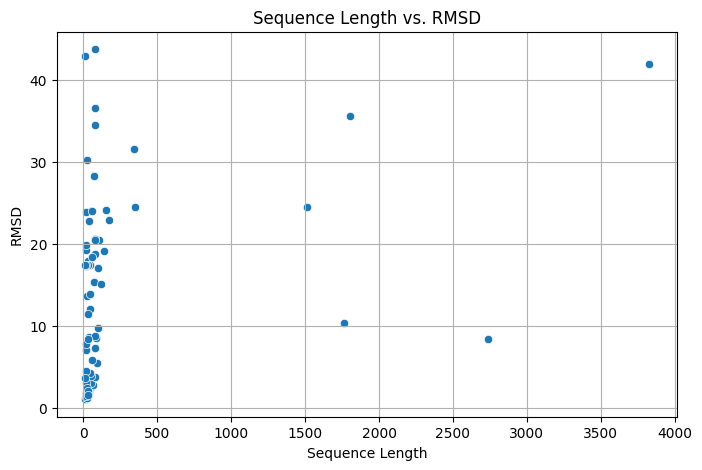

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


🧪 RMSD with shuffled input features: 27.4607

📏 Sequence Length Stats:
Train Set - Mean: 162.12, Std: 511.24, Min: 11, Max: 4298
Val Set   - Mean: 191.20, Std: 586.77, Min: 11, Max: 3825


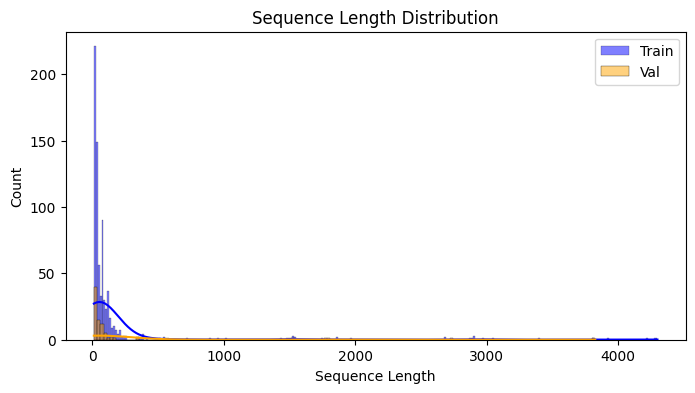

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader
from tqdm import tqdm

# Assuming merged, train_ids, val_ids, model, scaler, etc. are already defined from previous script

# 1. ✅ Check for Data Leakage
train_set = set(train_ids)
val_set = set(val_ids)
intersect = train_set & val_set
print("🔍 Data Leakage Check:")
if intersect:
    print(f"⚠️ Leakage detected! {len(intersect)} overlapping target IDs")
else:
    print("✅ No data leakage between train and validation sets.")

# 2. 📊 Plot Length vs. Accuracy
def per_sequence_metrics(graphs, predictions, truths):
    per_seq_rmsd, lengths = [], []
    lengths_per_graph = [g.num_nodes for g in graphs]

    start = 0
    for l in lengths_per_graph:
        pred_seq = predictions[start:start + l]
        true_seq = truths[start:start + l]
        rmsd = np.sqrt(np.mean((pred_seq - true_seq) ** 2))
        per_seq_rmsd.append(rmsd)
        lengths.append(l)
        start += l

    return np.array(lengths), np.array(per_seq_rmsd)

lengths, rmsds = per_sequence_metrics(val_graphs, predictions, true)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=lengths, y=rmsds)
plt.title("Sequence Length vs. RMSD")
plt.xlabel("Sequence Length")
plt.ylabel("RMSD")
plt.grid(True)
plt.show()

# 3. 🧪 Test with Noisy/Decoy Inputs
def create_noisy_graphs(val_graphs):
    noisy_graphs = []
    for g in val_graphs:
        noisy = g.clone()
        noisy.x = noisy.x[torch.randperm(noisy.num_nodes)]  # Shuffle node features
        noisy_graphs.append(noisy)
    return noisy_graphs

model.eval()
noisy_graphs = create_noisy_graphs(val_graphs)
noisy_loader = DataLoader(noisy_graphs, batch_size=1)
noisy_preds = []
with torch.no_grad():
    for batch in noisy_loader:
        batch = batch.to(device)
        pred = model(batch)
        noisy_preds.append(pred.cpu().numpy())

noisy_preds = np.concatenate(noisy_preds, axis=0)
noisy_rmsd = calculate_rmsd(true, noisy_preds)
print(f"🧪 RMSD with shuffled input features: {noisy_rmsd:.4f}")

# 4. 📈 Sequence Length Statistics
seq_lengths = merged.groupby('target_id').size()
train_lengths = seq_lengths[seq_lengths.index.isin(train_ids)]
val_lengths = seq_lengths[seq_lengths.index.isin(val_ids)]

print("\n📏 Sequence Length Stats:")
print(f"Train Set - Mean: {train_lengths.mean():.2f}, Std: {train_lengths.std():.2f}, Min: {train_lengths.min()}, Max: {train_lengths.max()}")
print(f"Val Set   - Mean: {val_lengths.mean():.2f}, Std: {val_lengths.std():.2f}, Min: {val_lengths.min()}, Max: {val_lengths.max()}")

plt.figure(figsize=(8, 4))
sns.histplot(train_lengths, label="Train", kde=True, color="blue")
sns.histplot(val_lengths, label="Val", kde=True, color="orange")
plt.title("Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Then save it to your drive
torch.save(model.state_dict(), '/content/drive/MyDrive/GCNConv_Model.pth')
joblib.dump(scaler, '/content/drive/MyDrive/GCNConc_Scaler.save')

print("Saved to Google Drive as 'GCNConv_Model.pth'")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to Google Drive as 'GCNConv_Model.pth'
